In [46]:
import os
import math
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import csv
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import feature_selection, linear_model

# Load in the Data

In [47]:
df = pd.read_csv('C:/Users/Collin/Documents/DAT-ATX-2/final_project/data/Bid_Data.csv')

# Format the Data

In [48]:
df = df[df['Rank'] == 1]
df = df[df['Type'] == 'Construction']

df = df.drop(' From', 1)
df = df.drop('To', 1)
df = df.drop('Contract Description', 1)
df = df.drop('Contractor', 1)
df = df.drop('Contract Category', 1)
df = df.drop('LNG MON', 1)
df = df.drop('MONTH', 1)

df['Award Amount'] = df['Award Amount'].str.lstrip('$')
df['Engineers Estimate'] = df['Engineers Estimate'].str.lstrip('$')
df['Award Amount'] = df['Award Amount'].str.replace(',','').astype(float)
df['Engineers Estimate'] = df['Engineers Estimate'].str.replace(',','').astype(float)

#Renaming Variables
df['EngEst'] = df['Engineers Estimate']
df['NBidders'] = df['Number of Bidders']
df['Year'] = df['Calendar Year']
df['WinBid'] = df['Award Amount']

# Creating New Varialbes
df['Diff'] = df['EngEst'] - df['WinBid']
df['lnWinBid'] = np.log(df['WinBid'])
df['lnEngEst'] = np.log(df['EngEst'])
df['DiffLn'] = df['lnWinBid'] - df['lnEngEst']
df['Within10Percent'] = 1 
df['PercentOff'] = df['Diff'] / df['EngEst']
df['MoreOrLessThan10'] = 0
df['LessThan10'] = 0
df['MoreThan10'] = 0

df.loc[(df.PercentOff > .10) , 'Within10Percent'] = 0
df.loc[(df.PercentOff < -.10) , 'Within10Percent'] = 0
df.loc[(df.PercentOff > .10) , 'MoreOrLessThan10'] = 1
df.loc[(df.PercentOff < -.10) , 'MoreOrLessThan10'] = 2
df.loc[(df.PercentOff > .10) , 'MoreThan10'] = 1
df.loc[(df.PercentOff < -.10) , 'LessThan10'] = 1

print len(df)

5177


# We now need to build and train a model that can classify a bid as over or under the TxDOT estimate

Axes(0.125,0.125;0.775x0.775)


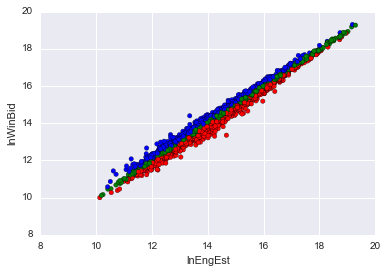

In [49]:
cmap = {'0': 'g', '1': 'r', '2': 'b' }
df['cMoreOrLessThan10'] = df.MoreOrLessThan10.apply(lambda x: cmap[str(x)])
print df.plot('lnEngEst', 'lnWinBid', kind='scatter', c=df.cMoreOrLessThan10)

Axes(0.125,0.125;0.775x0.775)


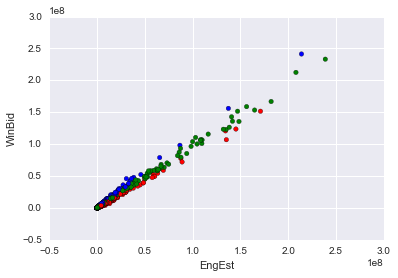

In [34]:
cmap = {'0': 'g', '1': 'r', '2': 'b' }
df['cMoreOrLessThan10'] = df.MoreOrLessThan10.apply(lambda x: cmap[str(x)])
print df.plot('EngEst', 'WinBid', kind='scatter', c=df.cMoreOrLessThan10)

# Classifying using K-Nearest Neighbor

Train the model with

In [50]:
from sklearn import neighbors, metrics

knn = neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance')
knn.fit(df[['lnEngEst','Year','NBidders','Time','Length']], df.MoreOrLessThan10)

knn.predict(df[['lnEngEst','Year','NBidders','Time','Length']])

df['knnMoreOrLessThan10'] = knn.predict(df[['lnEngEst','Year','NBidders','Time','Length']])
knn.score(df[['lnEngEst','Year','NBidders','Time','Length']], df.MoreOrLessThan10)

1.0

In [51]:
df['knnLessThan10'] = 0
df['knnMoreThan10'] = 0
df.loc[(df.knnMoreOrLessThan10 == 1) , 'knnMoreThan10'] = 1
df.loc[(df.knnMoreOrLessThan10 == 2) , 'knnLessThan10'] = 1

for weights in ['uniform', 'distance']:
    score = []
    for n in range(1,100):
        clf = neighbors.KNeighborsClassifier(n, weights = weights)
        clf.fit(df[['lnEngEst','Year','NBidders','Time','Length']], df.MoreOrLessThan10)
        score.append(clf.score(df_train[['lnEngEst','Year','NBidders','Time','Length']], df_train.MoreOrLessThan10))
    print score

# Split the Data

In [52]:
df_train = df[df.Year != 2016]

df_test = df[df.Year == 2016]

# TxDot considers bids over or under the estimate by more than 10% as bad

# We can then use this score to judge our model predictions

In [53]:
#Using ALL the Data

Percent = float(df.Within10Percent.sum()) / len(df)
print  (Percent)*100 , '% of All the TxDOT estimates were within 10% of actual bid'

Percent_2016 = float(df_test.Within10Percent.sum()) / len(df_test)
print  (Percent_2016)*100 , '% of the 2016 TxDOT estimates were within 10% of actual bid'

50.3380336102 % of All the TxDOT estimates were within 10% of actual bid
41.0852713178 % of the 2016 TxDOT estimates were within 10% of actual bid


In [70]:
model = smf.ols(formula = 'lnWinBid ~ lnEngEst+knnMoreThan10+knnLessThan10+Year+NBidders+NBidders*Year+Time', data = df_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               lnWinBid   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.789e+05
Date:                Tue, 17 May 2016   Prob (F-statistic):               0.00
Time:                        13:26:05   Log-Likelihood:                 4975.1
No. Observations:                4919   AIC:                            -9934.
Df Residuals:                    4911   BIC:                            -9882.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept       -13.9379      3.296     -4.228      0.000       -20.400    -7.476
lnEngEst          0.9921      0.001    784.217      0.000         0.990     0.995
knnMoreThan10    -0.2045      0.003    -68.347      0.000        -0.210    -0.199
knnLessThan10     0.2059      0.003     60.454      0.000         0.199     0.213
Year              0.0070      0.002      4.261      0.000         0.004     0.010
NBidders          2.2476      0.651      3.455      0.001         0.972     3.523
NBidders:Year    -0.0011      0.000     -3.463      0.001        -0.002    -0.000
Time           6.771e-05   1.13e-05      5.973      0.000      4.55e-05  8.99e-05
==============================================================================
Omnibus:                     1568.903   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37221.431
Skew:                          -0.973   Prob(JB):                         0.00
Kurtosis:                      16.335   Cond. No.                     2.79e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.79e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [71]:
df_test['Lnprediction'] = model.predict(df_test[['lnEngEst','knnMoreThan10','knnLessThan10','Year','NBidders','Time']])
df_test['BidPrediction'] = np.exp(df_test['Lnprediction'])

C:\Users\Collin\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Collin\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [72]:
df_test['PredDiff'] = df_test['BidPrediction'] - df_test['WinBid']
df_test['PredPercentOff'] = df_test['PredDiff'] / df_test['BidPrediction']

df_test['PredWithin10Percent'] = 1
df_test.loc[(df_test.PredPercentOff > .10) , 'PredWithin10Percent'] = 0
df_test.loc[(df_test.PredPercentOff < -.10) , 'PredWithin10Percent'] = 0

C:\Users\Collin\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Collin\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Collin\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [73]:
ModelPercent = float(df_test.PredWithin10Percent.sum()) / len(df_test)
PercentIncrease = (ModelPercent)*100 - (Percent_2016)*100
NumberCorrectIncrease = (PercentIncrease/100)*len(df_test)
print  (Percent_2016)*100 , '% of the TxDOT estimates were within 10% of actual bid'
print  (ModelPercent)*100 , '% of the Model predictions were within 10% of actual bid'
print 
print 'this is a increase of :', PercentIncrease, '%'
print 'or', NumberCorrectIncrease, 'more estimates within the 10% threshhold'

41.0852713178 % of the TxDOT estimates were within 10% of actual bid
82.1705426357 % of the Model predictions were within 10% of actual bid

this is a increase of : 41.0852713178 %
or 106.0 more estimates within the 10% threshhold


In [90]:
print 'In 2016 TxDOT over estimated bids by: ' , df_test.Diff.sum()
print
print 'In 2016 the Model over estimated bids by: ' ,df_test.PredDiff.sum()
print
print 'In 2016 the model was ' , df_test.Diff.sum() - df_test.PredDiff.sum() , 'closer to the winning bids than TxDOT' 
print
print 'The model predicted a sum of' ,df_test.BidPrediction.sum() ,'for all the projects in 2016'
print
print 'TxDOT predicted a sum of' ,df_test.EngEst.sum() ,'for all the projects in 2016'

In 2016 TxDOT over estimated bids by:  31391855.72

In 2016 the Model over estimated bids by:  -8778461.1485

In 2016 the model was  40170316.8685 closer to the winning bids than TxDOT

The model predicted a sum of 1107535226.62 for all the projects in 2016

TxDOT predicted a sum of 1147705543.49 for all the projects in 2016


In [94]:
df_test[['Diff','PredDiff']].std()

Diff        1.008437e+06
PredDiff    6.765534e+05
dtype: float64

In [93]:
df_test[['Diff','PredDiff']].describe()

,Diff,PredDiff
count,2.580000e+02,2.580000e+02
mean,1.216739e+05,-3.402504e+04
std,1.008437e+06,6.765534e+05
min,-5.178236e+06,-9.019693e+06
25%,-8.904980e+04,-8.224543e+04
50%,5.925246e+04,6.083257e+03
75%,3.868020e+05,8.575554e+04
max,4.209731e+06,1.952086e+06


Axes(0.125,0.125;0.775x0.775)


C:\Users\Collin\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


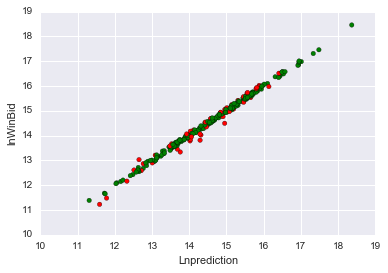

In [102]:
predcmap = {'0': 'r', '1': 'g' }
df_test['cPredWithin10Percent'] = df_test.PredWithin10Percent.apply(lambda x: predcmap[str(x)])
print df_test.plot('Lnprediction', 'lnWinBid', kind='scatter', c=df_test.cPredWithin10Percent)

Axes(0.125,0.125;0.775x0.775)


C:\Users\Collin\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


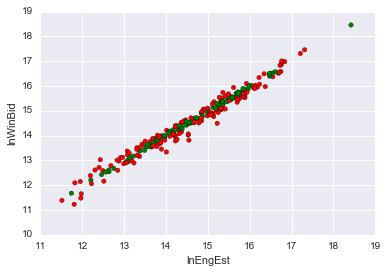

In [103]:
cmap = {'0': 'r', '1': 'g' }
df_test['cWithin10Percent'] = df_test.Within10Percent.apply(lambda x: cmap[str(x)])
print df_test.plot('lnEngEst', 'lnWinBid', kind='scatter', c=df_test.cWithin10Percent)